
Подключение нужных библиотек и определение требуемых функций

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl
import xlrd
import sklearn
import math
import os
import re
import copy
from numba import njit
from numba import prange
import plotly

plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go
from time import time
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error,mean_squared_error

from os import listdir
from os.path import isfile, join

In [110]:
from matplotlib.lines import Line2D
sns.axline = Line2D
sns.set(rc={'figure.figsize': (9,6)})

Функция подсчета среднего значения в списке

In [114]:
def average_in_list(list):
    """
    Функция подсчета среднего значения в списке
    param: list -- список для поиска среднего

    return summ / len(list) -- среднее значения в списке
    """
    summ = 0
    for i in list:
        summ += i
    return summ / len(list)

Функция для считывания данных из отчетных файлов ПО Abaqus

In [115]:
def read_data_txt_np(name_of_file, example_dir):
    """
    Функция для считывания данных из отчетных файлов ПО Abaqus
    params:
    name_of_file -- имя файла
    example_dir -- директория файла

    return:
    data -- считанные данные
    """
    data_flag = 0
    content = os.listdir(example_dir)
    if os.path.isfile(os.path.join(example_dir, name_of_file)):
        if name_of_file in content:
            file = os.path.join(example_dir, name_of_file)
            if file.endswith('.txt'):
                # data = np.loadtxt(file, dtype='double', skiprows=56) #thermal
                data = np.loadtxt(file, dtype='double', skiprows=44) #isothermal
                data_flag = 1
            else:
                print(f'{file} doesnt ends with .txt')
        else: 
            print(f"No file {name_of_file} in such dir")
    else:
        print(f"No such file {name_of_file}")
        return -1
    return data 

In [116]:
def files_list(list_one, dir_):
    """
    Функция для считывания данных для переданого списка
    params:
    list_one -- список файлов
    dir_ -- директория файлов

    return:
    list_files -- список считанных данных 
    """
    list_files = []
    for i in range(0, len(list_one)):
        file = read_data_txt_np(list_one[i], dir_)
        list_files.append(file)

    return list_files

In [117]:
def median_np(x):
    """ Построение медианы по переданному списку """
    return np.median(x)

In [118]:
def preprocessing_res_np(file):
    """
    Создание np.array по репорту
    params:
    file -- считааные из `read_data_txt_np` данные

    return:
    x_1_    -- массив х координат узлов решетки 
    y_1_    -- массив у координат узлов решетки
    Stress  -- массив массивов компонент тензора напряжений и интенсивностей напряжений
    Strain  -- массив массивов компонент тензора деформаций и интенсивностей деформаций 
    """
    x_1 = (file[::, 1]) * 10 ** 3
    y_1 = (file[::, 2]) * 10 ** 3

    eps_11_name = file[::, 11]
    eps_22_name = file[::, 12]
    eps_33_name = file[::, 13]
    eps_12_name = file[::, 14]

    stress_11_name = (file[::, 3]) / 10 ** 6
    stress_22_name = (file[::, 4]) / 10 ** 6
    stress_33_name = (file[::, 5]) / 10 ** 6
    stress_12_name = (file[::, 6]) / 10 ** 6

    #nt11_name = (file[::,15])
    #temp_name = (file[::,16])

    index = 0

    x_1_ = np.zeros((1, 1))
    y_1_ = np.zeros((1, 1))
    Strain = np.zeros((1, 5))
    Stress = np.zeros((1, 5))
    #NT11 = np.zeros((1, 1))
    #TEMP = np.zeros((1, 1))
    #ind_ = np.zeros((1,1))
    for j in range(0, np.shape(y_1)[0]):
        if y_1[j] >= 0.25 * (np.max(y_1) - np.min(y_1)) and y_1[j] <= 0.75 * (np.max(y_1) - np.min(y_1)):
            x_1_[index] = x_1[j]
            y_1_[index] = y_1[j]
            #ind_[index] = j

            Stress[index, 0] = stress_11_name[j]
            Stress[index, 1] = stress_22_name[j]
            Stress[index, 2] = stress_33_name[j]
            Stress[index, 3] = stress_12_name[j]
            Stress[index, 4] = (1 / (np.sqrt(2))) * np.sqrt(
                (stress_11_name[j] - stress_22_name[j]) ** 2 + (stress_22_name[j] - stress_33_name[j]) ** 2 + (
                        stress_33_name[j] - stress_11_name[j]) ** 2 + 6 * (stress_12_name[j] ** 2))

            Strain[index, 0] = eps_11_name[j]
            Strain[index, 1] = eps_22_name[j]
            Strain[index, 2] = eps_33_name[j]
            Strain[index, 3] = eps_12_name[j]
            Strain[index, 4] = (1 / (np.sqrt(2))) * np.sqrt(
                (eps_11_name[j] - eps_22_name[j]) ** 2 + (eps_22_name[j] - eps_33_name[j]) ** 2 + (
                        eps_33_name[j] - eps_11_name[j]) ** 2 + 6 * (eps_12_name[j] ** 2))

            #NT11[index]=nt11_name[j]
            #TEMP[index]=temp_name[j]

            x_1_ = np.concatenate((x_1_, np.zeros((1, 1))))
            y_1_ = np.concatenate((y_1_, np.zeros((1, 1))))
            Stress = np.concatenate((Stress, np.zeros((1, 5))))
            Strain = np.concatenate((Strain, np.zeros((1, 5))))
            #NT11 = np.concatenate((NT11,np.zeros((1,1))))
            #TEMP = np.concatenate((TEMP,np.zeros((1,1))))
            index = index + 1

    x_1_ = np.delete(x_1_, -1)
    y_1_ = np.delete(y_1_, -1)
    Stress = np.delete(Stress, -1, axis=0)
    Strain = np.delete(Strain, -1, axis=0)

    x_1_, characteristics = sorter(x_1_, [y_1_, Stress, Strain])
    y_1_, Stress, Strain = characteristics[0], characteristics[1], characteristics[2]

    return x_1_, y_1_, Stress, Strain

In [120]:
def average_val_np(array_1, nodes=13):
    """ Построение осредненных распределений """
    b = np.zeros((nodes))
    for i in range(0, nodes):
        b[i] = np.median(np.array_split(array_1, nodes)[i])

    return b

In [137]:
def get_param(cur_job_name, vel20List, all20Arrays, char_1=2, char_2=4):
    """
    Функция для извлечения зависимых и независимых переменных для 1 расчета
    params:
    cur_job_name -- название расчетного файла до точки
    vel20List -- список всех имен расчетных файов
    all20Arrays -- список предобработанных данных
    char_1 -- индекс характеристики (2-напряжения, 3-деформации)
    char_2 -- индекс компоненты тензора, 4 - интенсивность

    return:
    [red, cal, ha, vel, fric, char] -- список требуемых характеристик 
    (обжатие, коэффициент калибровочного участка, полуугол волоки, скорость, трение и искомая характеристика соотвественно) 
    """
    int_res_stress_idx = vel20List.index(cur_job_name)
    
    char = average_val_np(all20Arrays[int_res_stress_idx][char_1][::, char_2], 20)
    
    red = r(cur_job_name)
    cal = c(cur_job_name)
    ha = h(cur_job_name)
    vel = v(cur_job_name)
    fric = f(cur_job_name)

    return [red, cal, ha, vel, fric, char]

In [145]:
def sorter(xx, heap_of_stresses):
    """
    Сортирует по возрастанию узлы по значению расстояния от оси проволоки и
        перегруппировывает значения в остальных массивах в соответствии с новыми
        значениями индексов, но больше не удаляет точку (0,0)
    :param xx: значения координат х
    :param heap_of_stresses: список характеристик
    :return: x_sorted, heap_of_stresses_sorted
    """

    heap_of_stresses_sorted = heap_of_stresses[:]
    ai = np.argsort(xx, axis=0)
    x_sorted = np.take_along_axis(xx, ai, axis=0)
    ai = ai.flatten()

    for idx, i in enumerate(heap_of_stresses):
        ai_i = np.copy(ai)
        if i.ndim > 1:    # alternatively use np.tile instead
            for j in range(i.shape[1]-1):
                ai_i = np.vstack((ai_i, ai))
            ai_i = ai_i.T
        heap_of_stresses_sorted[idx] = np.take_along_axis(i, ai_i, axis=0)
        # heap_of_stresses_sorted[idx] = np.delete(heap_of_stresses_sorted[idx], delete_idx)

    return x_sorted, heap_of_stresses_sorted

In [148]:
def r(job_name):
    """
    Ищет обжатие по переданному имени файла
    """
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'red':
            found = splitted_job[i+1]
    reduct = float(found) / 10000
    return reduct

def c(job_name):
    """
    Ищет коэффициент калибровочного участка по переданному имени файла
    """
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'cal':
            found = splitted_job[i+1]
    cali = float(found) / 100
    return cali


def f(job_name):
    """
    Ищет к-т трения по переданному имени файла
    """
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'fric':
            found = splitted_job[i+1][1:]
    fr = float(found) / 1000
    return fr

def v(job_name):
    """
    Ищет скорость по переданному имени файла
    """
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == 'vel':
            found = splitted_job[i+1]
    velo = int(found)
    return velo

def h(job_name):
    """
    Ищет полуугол по переданному имени файла
    """
    splitted_job = job_name.split('_')
    for i in range(len(splitted_job)):
        if splitted_job[i] == '2a':
            found = splitted_job[i+1]
    ha = int(found) / 2
    return ha

## Построение vel20List

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_import = '/content/drive/MyDrive/720'

rep_list = [fil[:-4] for fil in listdir(path_import) 
            if isfile(join(path_import, fil)) and fil.endswith('.txt')]

In [ ]:
vel20List = [fil for fil in rep_list if 'vel_20' in fil and '(' not in fil]

Препроцессинг имеющихся данных

In [ ]:
vel20ListFiles = []
for fi in vel20List:
    vel20ListFiles.append(fi + '.txt')
la = files_list(vel20ListFiles, path_import)
all20Arrays = []
for fl in la:
    all20Arrays.append(preprocessing_res_np(fl))
    print('.', end='')

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Построение ИНС

Подготовка 

In [ ]:
train_list = [fil for fil in vel20List if 'red_3000' not in fil]
print(len(train_list))
train_listFiles = []
for fi in train_list:
    train_listFiles.append(fi + '.txt')
la = files_list(train_listFiles, path_import)
train_arrays = []
for fl in la:
    train_arrays.append(preprocessing_res_np(fl))
    print('.', end='')

630
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [150]:
X_1 = np.zeros((len(train_list)*20, 6))
y_1 = np.zeros((len(train_list)*20, ))
for i, job_name in enumerate(train_list):
    red, cal, ha, vel, fric, int_res_stress = get_param(job_name, train_list, train_arrays)
    for j in range(20):
        X_1[i*20+j] = np.array([red, cal, ha, vel, fric, j/19])
        y_1[i*20+j] = int_res_stress[j]

Функция для подсчета средней ошибки для графиков

In [152]:
def max_graph_er(pred, ground_true):

    maxerror = 0 
    for i in range(0, len(pred)//20):
        cmape = sklearn.metrics.mean_absolute_percentage_error(pred[i*20:(i+1)*20], ground_true[i*20:(i+1)*20])*100
        maxerror = cmape if cmape > maxerror else maxerror

    return maxerror

# ВАЛИДАЦИОННЫЙ ДАТАСЕТ ИЗ ЦЕЛОГО ГРАФИКА

Составление датасетов для предсказания напряжений

In [ ]:
X = np.zeros((len(train_list), 4))
y = np.zeros((len(train_list), 20))
for i, job_name in enumerate(train_list):
    red, cal, ha, vel, fric, int_res_stress = get_param(job_name,
                                                        train_list,
                                                        train_arrays)

    X[i] = np.array([red, cal, ha, fric])
    y[i] = int_res_stress

In [ ]:
X_train_fair, X_val_fair, y_train_fair, y_val_fair = train_test_split(X, y, train_size=.8, random_state=50)

In [ ]:
def flatten_r(X_train_fair, y_train_fair):
    X_1 = np.zeros((len(X_train_fair)*20, X_train_fair.shape[1]+1))
    y_1 = np.zeros((len(X_train_fair)*20, ))
    for i in range(len(X_train_fair)):
        for j in range(20):
            X_1[i*20+j] = np.hstack((X_train_fair[i], j/19))
            y_1[i*20+j] = y_train_fair[i][j]
    return X_1, y_1

In [ ]:
X_train_fair, y_train_fair = flatten_r(X_train_fair, y_train_fair)
X_val_fair, y_val_fair = flatten_r(X_val_fair, y_val_fair)
print(X_train_fair.shape, X_val_fair.shape)

(10080, 5) (2520, 5)


Составление датасетов для предсказания деформаций

In [190]:
X_eps = np.zeros((len(train_list), 4))
y_eps = np.zeros((len(train_list), 20))
for i, job_name in enumerate(train_list):
    red, cal, ha, vel, fric, int_res_eps = get_param(job_name,
                                                        train_list,
                                                        train_arrays,
                                                        char_1=3
                                                        )

    X_eps[i] = np.array([red, cal, ha, fric])
    y_eps[i] = int_res_eps

In [191]:
X_train_fair_eps, X_val_fair_eps, y_train_fair_eps, y_val_fair_eps = train_test_split(X_eps, y_eps, train_size=.8, random_state=50)

In [192]:
X_train_fair_eps, y_train_fair_eps = flatten_r(X_train_fair_eps, y_train_fair_eps)
X_val_fair_eps, y_val_fair_eps     = flatten_r(X_val_fair_eps, y_val_fair_eps)
print(X_train_fair_eps.shape, X_val_fair_eps.shape)

(10080, 5) (2520, 5)


In [ ]:
def special_ann_stress_strains_val(fname, range_layers, range_neurons, X_train_fair, y_train_fair, X_val_fair, y_val_fair, alpha, solver):
    cscores = []
    aics = []
    bics = []
    mapes = []
    mspes = []
    n_layers = []
    n_neurons = []

    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_fair, y_train_fair, train_size=.6, random_state=100)

    K = X_train_1.shape[1]
    n = len(y_test_1)
    v_r2 = ((y_test_1 - y_test_1.mean()) **2).sum()
    all_v_r2 = ((y - y.mean()) **2).sum()
    for j in range_neurons:
        j = j-1
        for i in range_layers:
            hls_tuple = ()
            for _ in range(1, i+1):
                hls_tuple = hls_tuple + (j+1, )
            n_layers.append(i)
            n_neurons.append(j+1)
            regr = make_pipeline(StandardScaler(),
                                MLPRegressor(hidden_layer_sizes=hls_tuple,
                                            #  learning_rate_init=0.0001,
                                            random_state=100,
                                            #  alpha=alpha,
                                             early_stopping=True,
                                             solver=solver,
                                            # verbose=True,
                                            max_iter=45000
                                             ),)
            regr.fit(X_train_1,y_train_1)
            # # Calc R^2
            cscore = regr.score(X_test_1, y_test_1)
            cscores.append(cscore)
            # R^2 to mspe:
            # R^2 = 1 - u / v, where u is sum of square errors ((y_true - y_pred) **2).sum() and v is the total sum of squares ((y_true - y_true.mean()) **2).sum() .
            u_r2 = - (cscore - 1) * v_r2
            # Calc AIC
            aic_ = n * np.log(u_r2 / n) + 2*K
            aics.append(aic_)

            # Calc BIC
            bic_ = aic_ - 2*K + K*np.log(n)
            bics.append(bic_)

            # Calc MAPE
            ypred = regr.predict(X_test_1)
            mape = ((abs(ypred - y_test_1)) / (abs(y_test_1) + 1e-8)).mean()*100
            mapes.append(mape)
            mspe = (((abs(ypred - y_test_1)) / (abs(y_test_1) + 1e-8))**2).mean()*100
            mspes.append(mspe)
            
            
            print(f'for {i:>3} hidden layers of size {j+1:>3}  MAPE = {mape:.3f}, MSPE = {mspe:.3f}, AIC = {aic_:.3f}, cscore = {cscore:.3f}, BIC = {bic_:.3f}')
            # print(f'All MAPE = {all_mape:.3f}, MSPE = {all_mspe:.3f}, AIC = {all_aic_:.3f}, cscore = {all_cscore:.3f}, BIC = {all_bic_:.3f}')
            # to_save_data = {
            #         'n_layers' : n_layers,
            #         'n_neurons' : n_neurons,
            #         'cscores' : cscores,
            #         'aics' : aics,
            #         'bics' : bics,
            #         'mapes' : mapes,
            #         'mspes' : mspes
            #     }

            # json_string = json.dumps(to_save_data)
            # with open('/content/drive/MyDrive/' + fname +'.json', 'w') as outfile:
            #     json.dump(json_string, outfile)  

            val_mape = sklearn.metrics.mean_absolute_percentage_error(regr.predict(X_val_fair), y_val_fair)*100
            max_error_on_graph = max_graph_er(regr.predict(X_val_fair), y_val_fair)
            print(f'{solver} for {i:>3} hidden layers of size {j+1:>3} VAL MAPE = {val_mape:.3f}, max_error_on_graph = {max_error_on_graph}')

    return regr          

In [ ]:
 sassv1210 = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[12],
                                        range_neurons= [10],
                                        X_train_fair=X_train_fair, y_train_fair=y_train_fair, X_val_fair=X_val_fair, y_val_fair=y_val_fair,
                                        alpha=0.4, solver='lbfgs')

lbfgs for  12 hidden layers of size  10 VAL MAPE = 8.539, max_error_on_graph = 21.10561109024685


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [ ]:
sassv = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[10],
                                        range_neurons= [10],
                                        X_train_fair=X_train_fair, y_train_fair=y_train_fair, X_val_fair=X_val_fair, y_val_fair=y_val_fair,
                                        alpha=0.4, solver='lbfgs')

lbfgs for  10 hidden layers of size  10 VAL MAPE = 7.759, max_error_on_graph = 19.52704627587112


In [153]:
sassv715 = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[7],
                                        range_neurons= [15],
                                        X_train_fair=X_train_fair, y_train_fair=y_train_fair, X_val_fair=X_val_fair, y_val_fair=y_val_fair,
                                        alpha=0.4, solver='lbfgs')

for   7 hidden layers of size  15  MAPE = 6.799, MSPE = 1.493, AIC = 14018.152, cscore = 0.981, BIC = 14049.662
lbfgs for   7 hidden layers of size  15 VAL MAPE = 7.292, max_error_on_graph = 17.915481526564154


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [ ]:
sassv715 = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[7],
                                        range_neurons= [15],
                                        X_train_fair=X_train_fair, y_train_fair=y_train_fair, X_val_fair=X_val_fair, y_val_fair=y_val_fair,
                                        alpha=0.4, solver='lbfgs')

for   7 hidden layers of size  15  MAPE = 6.799, MSPE = 1.493, AIC = 14018.152, cscore = 0.981, BIC = 14049.662
lbfgs for   7 hidden layers of size  15 VAL MAPE = 7.292, max_error_on_graph = 33.476448173970354


In [ ]:
sassv2010 = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[20],
                                        range_neurons= [10],
                                        X_train_fair=X_train_fair_eps, y_train_fair=y_train_fair_eps, X_val_fair=X_val_fair_eps, y_val_fair=y_val_fair_eps,
                                        alpha=0.4, solver='adam')

adam for  20 hidden layers of size  10 VAL MAPE = 4.562, max_error_on_graph = 12.922422588827551


In [ ]:
sassv1610 = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[16],
                                        range_neurons= [10],
                                        X_train_fair=X_train_fair_eps, y_train_fair=y_train_fair_eps, X_val_fair=X_val_fair_eps, y_val_fair=y_val_fair_eps,
                                        alpha=0.4, solver='adam')

adam for  16 hidden layers of size  10 VAL MAPE = 2.925, max_error_on_graph = 11.76521919294696


In [195]:
sassv1610_ = special_ann_stress_strains_val(fname='test_solver', 
                                        range_layers=[16],
                                        range_neurons= [10],
                                        X_train_fair=X_train_fair_eps, y_train_fair=y_train_fair_eps, X_val_fair=X_val_fair_eps, y_val_fair=y_val_fair_eps,
                                        alpha=0.4, solver='adam')

for  16 hidden layers of size  10  MAPE = 3.161, MSPE = 0.305, AIC = -34843.851, cscore = 0.998, BIC = -34812.341
adam for  16 hidden layers of size  10 VAL MAPE = 2.925, max_error_on_graph = 10.274669747099193


In [ ]:
# Set the font size for the labels and ticks
plt.rcParams['font.size'] = 24
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})
sns.set_theme(style='darkgrid')
for i in range(0, len(X_val_fair)//20):
# for i in range(0, 1):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.plot(np.linspace(0, 1, 20),
            sassv715.predict(X_val_fair_eps[i*20:(i+1)*20]),
            linewidth=3,
            label='Предсказание модели'
            )
    ax.plot(np.linspace(0, 1, 20),
            y_val_fair_eps[i*20:(i+1)*20],
            linewidth=3,
            label='Истинные данные'
            )
    # sns.axes_style("darkgrid")
    # plt.ylabel(r'$\varepsilon_i, -$', fontsize=24)
    plt.ylabel(r'$\sigma_i, $МПа', fontsize=24)
    plt.xlabel('$r, -$', fontsize=24)

    leg = ax.legend(loc='best', fontsize=24)

    # Make the ticks bigger
    ax.tick_params(axis='both', which='major', labelsize=20)

    # ax.set_title('Title', fontsize=14)
    description_array = X_val_fair[i*20][:-1]
    description = ''
    pars = ['red', 'cal', 'ha', 'fric']
    for co in range(len(description_array)):
        description += pars[co]
        description += str(description_array[co])
        description += '_'
    plt.subplots_adjust(bottom=0.15)

    plt.savefig('/content/drive/MyDrive/7_15+/' + description + '.png')
    # plt.show()

In [ ]:
for solver in ('lbfgs', 'adam', 'sgd'):
    special_ann_stress_strains_val(fname='test_solver', 
                                           range_layers=range(12, 21, 4),
                                           range_neurons= [3, 5, 7, 10, 15, 25, 30, 50, 75, 100],
                                           X_train_fair=X_train_fair, y_train_fair=y_train_fair, X_val_fair=X_val_fair, y_val_fair=y_val_fair,
                                           alpha=0.4, solver=solver)

In [193]:
for d in [5]:

    # CREATE POLY DATA SET FOR DEGREE "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features_eps = polynomial_converter.fit_transform(np.vstack((X_train_fair_eps, 
                                                                        X_val_fair_eps)))

    # SPLIT THIS NEW POLY DATA SET
    X_train, X_test = poly_features_eps[0: len(X_train_fair_eps)], poly_features_eps[len(X_train_fair_eps):]
    y_train, y_test = y_train_fair_eps.copy(), y_val_fair_eps.copy()
    K = 5
    n = len(y_test)
    
    v_r2 = ((y_test - y_test.mean())**2).sum()

    # TRAIN ON THIS NEW POLY SET
    model_eps = make_pipeline(StandardScaler(),
                              LinearRegression(fit_intercept=True))
    model_eps.fit(X_train,y_train)

    # PREDICT ON BOTH TRAIN AND TEST
    train_pred = model_eps.predict(X_train)
    test_pred = model_eps.predict(X_test)

    print('.', end='')
    # Calculate Errors

    # Errors on Train Set
    train_RMSE = sklearn.metrics.r2_score(y_train,train_pred)

    # Errors on Test Set
    test_RMSE = sklearn.metrics.r2_score(y_test,test_pred)
    mape = sklearn.metrics.mean_absolute_percentage_error(y_test, test_pred)
    u_r2 = - (test_RMSE - 1) * v_r2
    aic_ = n * np.log(u_r2 / n) + 2*K
    # Calc BIC
    bic_ = aic_ - 2*K + K*np.log(n)
    # Calc MAPE
    mape = ((abs(test_pred - y_test)) / (abs(y_test) + 1e-8)).mean()*100
    mspe = (((abs(test_pred - y_test)) / (abs(y_test) + 1e-8))**2).mean()*100

.

In [194]:
mape, aic_, bic_, test_RMSE

(7.1931963077086065,
 -17333.73986178277,
 -17304.579790880245,
 0.9866437532272304)

In [ ]:
# Set the font size for the labels and ticks
path_graph = '/content/drive/MyDrive/compar_ann+poly/'
if not  os.path.exists(path_graph):
     os.mkdir(path_graph)
plt.rcParams['font.size'] = 24
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})
sns.set_theme(style='darkgrid')
# for i in range(0, len(X_val_fair)//20):
for i in [2]:
    plt.clf()
        # Plot your data
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.plot(np.linspace(0, 1, 20),
            model_eps.predict(X_test[i*20:(i+1)*20]),
            linewidth=5,
            label='Предсказание полинома'
            )
    ax.plot(np.linspace(0, 1, 20),
            sassv715.predict(X_val_fair[i*20:(i+1)*20]),
            linewidth=5,
            label='Предсказание ИНС'
            )
    ax.plot(np.linspace(0, 1, 20),
            y_val_fair[i*20:(i+1)*20],
            linewidth=5,
            label='Истинные данные'
            )
    # sns.axes_style("darkgrid")
    plt.ylabel(r'$\varepsilon_i, -$', fontsize=42)
    # plt.ylabel(r'$\sigma_i, $МПа', fontsize=42)
    plt.xlabel('$r, -$', fontsize=42)

    leg = ax.legend(loc='best', fontsize=28)

    # Make the ticks bigger
    ax.tick_params(axis='both', which='major', labelsize=30)

    # ax.set_title('Title', fontsize=14)
    description_array = X_val_fair[i*20][:-1]
    description = ''
    pars = ['red', 'cal', 'ha', 'fric']
    for co in range(len(description_array)):
        description += pars[co]
        description += str(description_array[co])
        description += '_'
    # plt.subplots_adjust(bottom=0.15)
    # plt.subplots_adjust(right=0.8)

    ax.set_position([0.2, 0.15, 0.75, 0.8])
    plt.savefig(path_graph + description + '.png')
    plt.show()
    plt.close()

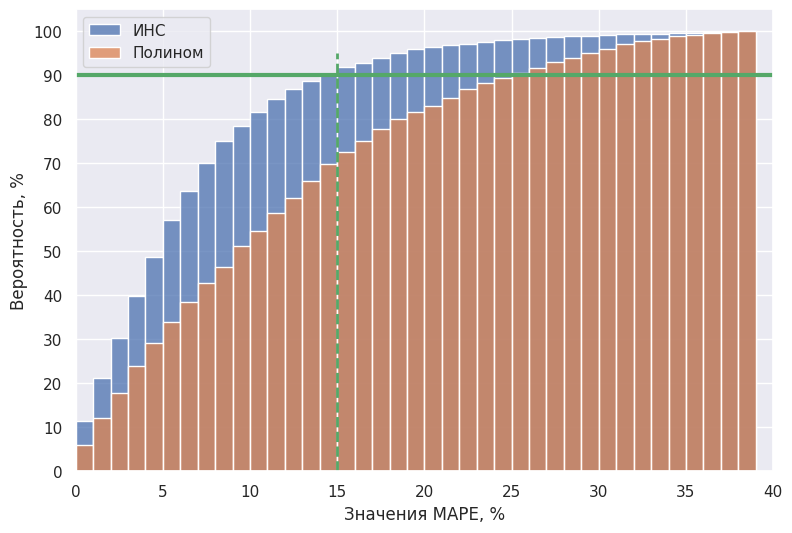

In [189]:
sns.histplot(sklearn.metrics.mean_absolute_percentage_error( y_val_fair.reshape(1, -1),sassv715.predict(X_val_fair).reshape(1, -1), multioutput='raw_values')*100
            , bins=range(40),
             stat='percent', fill=True,
            #   ,kde = True                #   
             
             cumulative=True,
             label='ИНС'
             )
g = sns.histplot(sklearn.metrics.mean_absolute_percentage_error(y_val_fair.reshape(1, -1),model_eps.predict(X_test).reshape(1, -1), multioutput='raw_values')*100
            , bins=range(40),
             stat='percent', fill=True,
            #   ,kde = True                #   
             cumulative=True,
             label='Полином'
             ).set(xlim=(0, 40), xlabel='Значения MAPE, %', ylabel='Вероятность, %')
plt.plot([0, 40], [90, 90], linewidth=3, color='g')
plt.plot([15, 15], [0, 95], linewidth=2, color='g', linestyle='--')
plt.yticks(np.arange(0, 101, 10))
plt.legend()

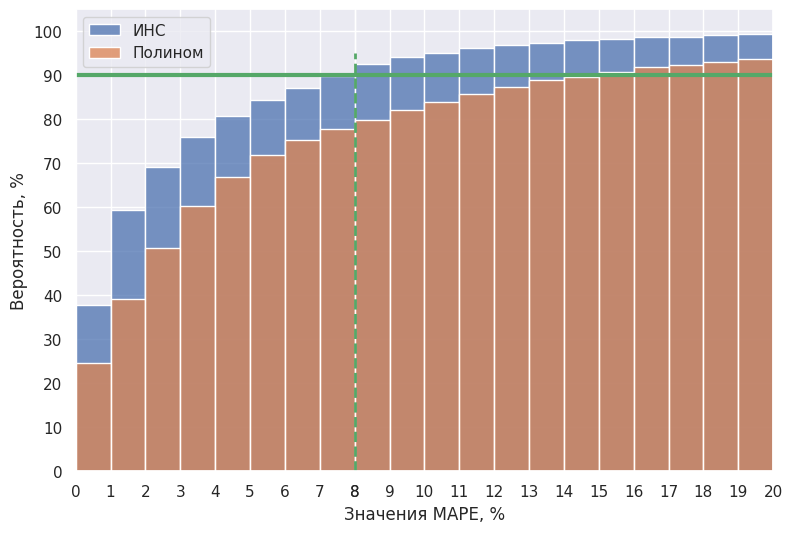

In [212]:
sns.histplot(sklearn.metrics.mean_absolute_percentage_error(y_val_fair_eps.reshape(1, -1),sassv1610_.predict(X_val_fair_eps).reshape(1, -1), multioutput='raw_values')*100
            , bins=range(40),
             stat='percent', fill=True,
            #   ,kde = True                #   
             
             cumulative=True,
             label='ИНС'
             )
g = sns.histplot(sklearn.metrics.mean_absolute_percentage_error(y_val_fair_eps.reshape(1, -1),model_eps.predict(X_test).reshape(1, -1), multioutput='raw_values')*100
            , bins=range(40),
             stat='percent', fill=True,
            #   ,kde = True                #   
             cumulative=True,
             label='Полином'
             ).set(xlim=(0, 20), xlabel='Значения MAPE, %', ylabel='Вероятность, %')
plt.plot([0, 40], [90, 90], linewidth=3, color='g')
# plt.plot([0, 40], [95, 95], linewidth=3, color='g')
plt.plot([8, 8], [0, 95], linewidth=2, color='g', linestyle='--')
plt.yticks(np.arange(0, 101, 10))
plt.xticks(np.concatenate((np.arange(0, 21, 1), [8])))
plt.legend()